In [79]:
import os
from typing import *
import operator

from dotenv import load_dotenv
load_dotenv()
from IPython.display import Image, display
import sqlite3


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt

In [80]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [81]:
# ------------------------------------------------------ #
# TOOLS
# ------------------------------------------------------ #


In [82]:
# ------------------------------------------------------ #
# MODELS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')
# tools = [add, multiply, divide]
# llm_with_tools = chat_llm.bind_tools(tools)

In [83]:
# ------------------------------------------------------ #
# REDUCERS
# ------------------------------------------------------ #
def sorting_reducer(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)

In [84]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
# class State(TypedDict):
#     state: str

class State(TypedDict):
    state: Annotated[list, sorting_reducer]

In [85]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Reassigning <<{self._value}>> to {state['state']}")
        return {'state': [self._value]}

In [86]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #


In [87]:
# ------------------------------------------------------ #
# MEMORY
# ------------------------------------------------------ #
memory = MemorySaver()

In [88]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
def workflow_simple():
    builder = StateGraph(State)
    # node
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edge
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("b", "c")
    builder.add_edge("c", "d")
    builder.add_edge("d", END)
    return builder

def workflow_fan_out():
    builder = StateGraph(State)
    # node
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edge
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("a", "c")
    builder.add_edge("b", "d")
    builder.add_edge("c", "d")
    builder.add_edge("d", END)
    return builder


def workflow_waiting():
    builder = StateGraph(State)
    # nodes
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("b2", ReturnNodeValue("I'm B2"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edges
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("a", "c")
    builder.add_edge("b", "b2")
    builder.add_edge(["b2", "c"], "d")
    builder.add_edge("d", END)
    return builder

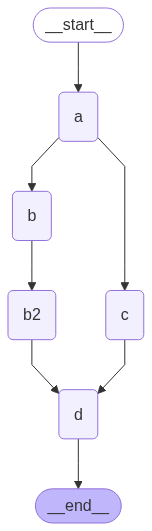

In [89]:
# ------------------------------------------------------ #
# COMPILE GRAPH
# ------------------------------------------------------ #
# workflow = workflow_simple()
# workflow = workflow_fan_out()
workflow = workflow_waiting()
graph = workflow.compile()
# graph = workflow.compile()
# print(graph.get_graph().draw_ascii())
display(Image(graph.get_graph().draw_mermaid_png()))

In [90]:
graph.invoke({'state': []})

Reassigning <<I'm A>> to []
Reassigning <<I'm B>> to ["I'm A"]Reassigning <<I'm C>> to ["I'm A"]

Reassigning <<I'm B2>> to ["I'm A", "I'm B", "I'm C"]
Reassigning <<I'm D>> to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

---

---

---

---

---

---

---

---

---

---

---

---

---

---

In [91]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
# class State(TypedDict):
#     state: str

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, sorting_reducer]

In [92]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
def search_web(state: State):
    """ Retrieve docs from web search """
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state: State):
    """ Retrieve docs from wikipedia """
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answers(state: State):
    """ Node to answer a question """
    context = state['context']
    question = state['question']

    answer_instructions = f"""Answer the question {question} using this context: {context}"""

    answer = chat_llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content="Answer the question.")])

    return {"answer": answer}

In [93]:
# ------------------------------------------------------ #
# BUILDERS
# ------------------------------------------------------ #
def workflow_search():
    builder = StateGraph(State)
    # nodes
    builder.add_node(search_web)
    builder.add_node(search_wikipedia)
    builder.add_node(generate_answers)
    # edges
    builder.add_edge(START, 'search_wikipedia')
    builder.add_edge(START, 'search_web')
    builder.add_edge('search_wikipedia', 'generate_answers')
    builder.add_edge('search_web', 'generate_answers')
    builder.add_edge('generate_answers', END)
    return builder

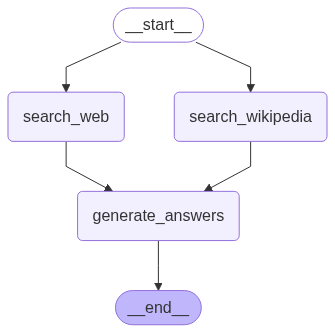

In [94]:
# ------------------------------------------------------ #
# COMPILE
# ------------------------------------------------------ #
workflow = workflow_search()
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [96]:
# ------------------------------------------------------ #
# INVOCATIONS
# ------------------------------------------------------ #
result = graph.invoke({'question': 'What is femboy?'})
print(result['answer'].content)

A femboy is a male who expresses or presents themselves with femininity, often incorporating elements such as traditionally feminine clothing, makeup, jewelry, and behaviors into their identity. This can include adopting certain mannerisms, hairstyles, or physical presentation that are typically associated with women. The term can be used to describe individuals who identify as male but also express a more feminine side of themselves, either partially or fully.

The use of the term femboy is often associated with online communities and social media platforms, where it has been popularized through hashtags and discussions around identity, self-expression, and acceptance. Some people use the term to describe their own experiences with femininity, while others may see it as a label for individuals who do not conform to traditional notions of masculinity.

It's worth noting that the term femboy is often used in contrast to other terms, such as "butch" or "sissy," which can carry different 